## Guided mutation: Shift lowest UMAP order tokens to higher values

In [1]:
from collections import Counter
import io
from multiprocessing import cpu_count
from pathlib import Path
import yaml

from aaindex.aaindex import aaindex
import numexpr
import numpy as np
import pandas as pd
from scipy import stats

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from scripts.general import analysis, data

tqdm.pandas(desc='Pandas op')
MAX_PROC = cpu_count() - 2
numexpr.set_num_threads(MAX_PROC)

_default_rc_params = plt.rcParams.copy()
plt.rcParams['font.size'] = 14

alt.renderers.enable('html')

%load_ext autoreload
%autoreload 2

Runs for the different mutation schemes were performed with the `scripts/informed_mutation.py` sript as

```bash
scripts/informed_mutation.py \
    --config results/20211223_182228/experiment_config.yaml \
    --num-mutated-residues X
```

where `X` was 2, 5, 10, 20, 10%, 20%, 30%

See [README](README.md)

The CSV outputs from all scheme runs were concatenated into `guided_mutation_results.csv.gz`.

**Predictions** have already been **inverse Box-Cox transformed.**

In [2]:
informed_mut_res = pd.read_csv(
    io.StringIO('''name,fname,log
fixed_02,informed_mutation_ca6f70f288dc11ecb991e1ef75376b7a.csv,slurm-195037.out
fixed_05,informed_mutation_b7b798f388db11ec9bff3704140e7db9.csv,slurm-195029.out
fixed_10,informed_mutation_f06bc50288db11ecbe6b390230713c4f.csv,slurm-195032.out
fixed_20,informed_mutation_1d6ee48f88dc11ec9a51d1a48702a2d2.csv,slurm-195033.out
percent_10,informed_mutation_49d6e7ba88dc11ec8bb0370c9d5bfe2e.csv,slurm-195034.out
percent_20,informed_mutation_68dcca6188dc11eca91d755d65979837.csv,slurm-195035.out
percent_30,informed_mutation_805c90f588dc11ecbcc6f1f79ca0643f.csv,slurm-195036.out'''
))

informed_mut_res = pd.merge(
    pd.concat(
        list(map(
            lambda fname: pd.read_csv('informed_mutation/' + fname).assign(fname=str(fname)),
            informed_mut_res['fname']
        ))
    ),
    informed_mut_res,
    on='fname'
).drop(columns='fname')

informed_mut_res = informed_mut_res.assign(
    percent = 100 * (informed_mut_res['pred_mut'] - informed_mut_res['pred_wt']) / informed_mut_res['pred_wt']
)
informed_mut_res = informed_mut_res.assign(
    control_percent = 100 * (informed_mut_res['pred_control'] - informed_mut_res['pred_wt']) / informed_mut_res['pred_wt']
)

informed_mut_res.to_csv('informed_mutation/guided_mutation_results.csv.gz', index=False, compression='gzip')

In [3]:
informed_mut_res.shape

(33215, 11)

In [4]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'Median_molecules_per_cell']
]
seq_data = seq_data.assign(
    abundance_bin = pd.qcut(seq_data['Median_molecules_per_cell'], q = 10, labels=range(1, 11))
)

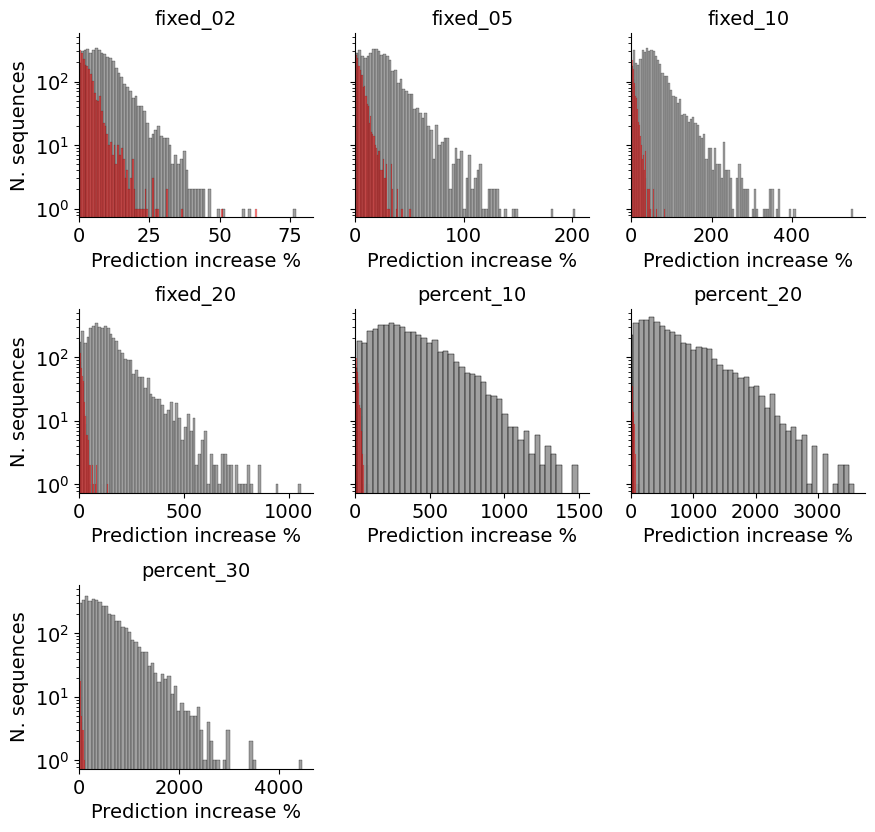

In [5]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14

g = sns.FacetGrid(informed_mut_res, 
                  col='name', col_wrap=3, sharex=False)

g.map(sns.histplot, 'percent', color='gray')
g.map(sns.histplot, 'control_percent', color='red', alpha=0.5)

g.set_titles(col_template="{col_name}")  #, row_template="{row_name}")
g.set_axis_labels('Prediction increase %', 'N. sequences')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xlim(left=0)
    ax.set_xlabel('Prediction increase %')
g.tight_layout()

g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Guided mutation increases')
    
# plt.xlim(1, 1200)
plt.yscale('log')

plt.savefig('guided_mutation.pdf')

In [6]:
informed_mut_res.groupby('name')['percent'].describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
fixed_02,4745.0,9.028363,7.221717,-2.350232,3.735786,7.588956,12.253544,77.263835
fixed_05,4745.0,24.939800,19.696063,-7.007552,11.284519,21.258071,32.726321,202.757510
fixed_10,4745.0,57.620799,47.394873,-23.063841,27.660009,48.450123,73.662797,551.483901
fixed_20,4745.0,141.583363,116.283295,-45.046539,66.381428,117.678675,182.091554,1061.015253
percent_10,4745.0,352.949877,231.671429,-24.683046,180.838748,309.731045,484.925044,1489.666944
percent_20,4745.0,674.971576,567.048784,-50.107646,251.912807,518.560094,978.814076,3585.483995
percent_30,4745.0,520.822210,465.329220,-71.217413,182.068227,415.759529,735.326598,4451.463862


In [7]:
informed_mut_res['percent'].max()

4451.463862383484

In [8]:
informed_mut_res['percent'].mean()

254.55942700849113

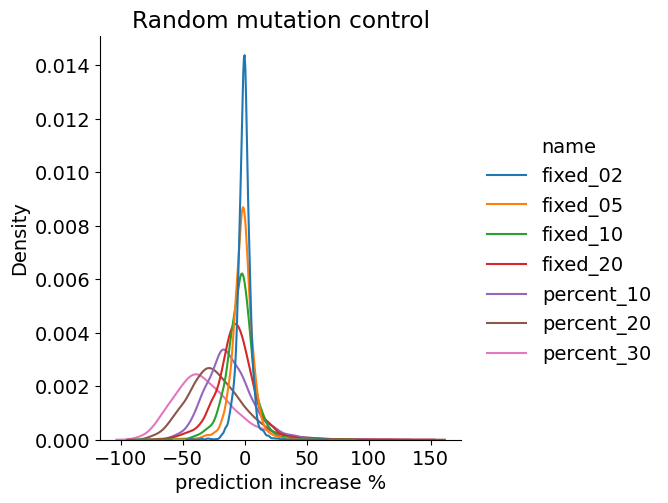

In [9]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14

sns.displot(data=informed_mut_res, x='control_percent',
            hue='name', kind='kde') #, alpha=0.3)
plt.xlabel('prediction increase %')
_ = plt.title('Random mutation control')

In [10]:
informed_mut_res.head(2)

,swissprot_ac,seq_wt,seq_mut,seq_mut_control,pred_wt,pred_mut,pred_control,name,log,percent,control_percent
0,P47095,MSSQDVLIHSDDPCHPANLICTLCKQFFHNNWCTGTGGGISIKDPN...,MSSQDVLIHSDDPCHPANLICTLCKQFFHNNWCTGTGGGISIKDPN...,MSSQDVLIHSDDPCHPANLICTLCKQFFHNNWCTGTGGGISIKDPN...,3555.971623,3963.140172,3560.023995,fixed_02,slurm-195037.out,11.450276,0.11396
1,P25360,MRFSHFLKYNAVPEWQNHYLDYNELKNLIYTLQTDELKQETPTGDL...,MRFSHFLKYNAVPEWQNHYLDYNELKNLIYTLQTDELKQETPTGDL...,MRFSHFLKYNAVPEWQNHYLDYNELKNLIYTLQTDELKQETPTGDL...,2379.983182,2414.865145,2388.297405,fixed_02,slurm-195037.out,1.465639,0.34934


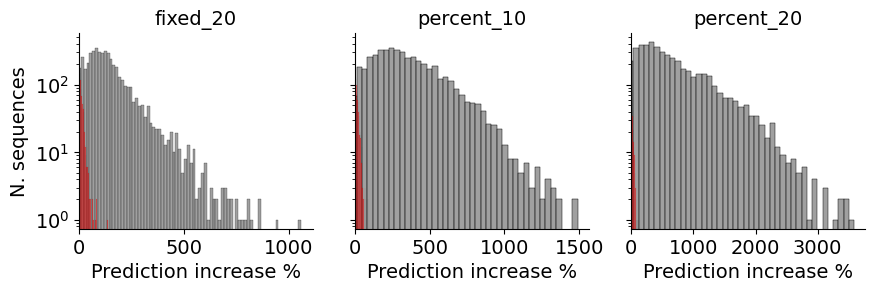

In [11]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14

highlight_list = ['fixed_20', 'percent_10', 'percent_20']

g = sns.FacetGrid(
    data = (
            informed_mut_res
            .query('name in @highlight_list')
            ), 
    col='name', col_wrap=3, sharex=False
)

g.map(sns.histplot, 'percent', color='gray')
g.map(sns.histplot, 'control_percent', color='red', alpha=0.5)

g.set_titles(col_template="{col_name}")  #, row_template="{row_name}")
g.set_axis_labels('Prediction increase %', 'N. sequences')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xlim(left=0)
    ax.set_xlabel('Prediction increase %')
g.tight_layout()

g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle('Guided mutation increases')
    
# plt.xlim(1, 1000)
plt.yscale('log')

plt.savefig('guided_mutation_highlight.pdf')

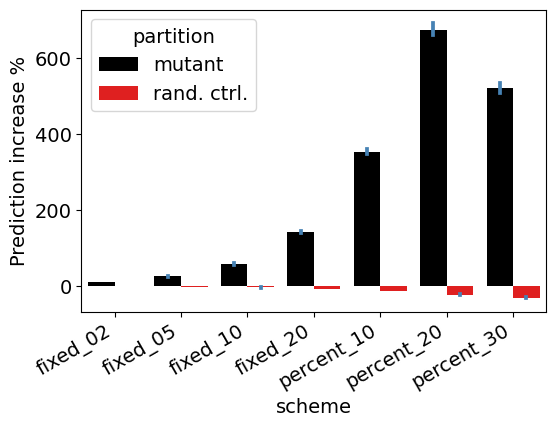

In [12]:
plt.figure(dpi=100, figsize=(6, 4))


sns.barplot(
    data = (
        informed_mut_res[['percent', 'control_percent', 'name']]
        .rename(columns = {'name': 'scheme', 'percent': 'mutant', 'control_percent': 'rand. ctrl.'})
#         .groupby(['scheme']).mean()
#         .reset_index()
        .melt(id_vars = 'scheme', var_name = 'partition', value_name = 'Prediction increase %')
    ),
    
    x = 'scheme',
    y = 'Prediction increase %',
    hue = 'partition',
    
    palette = {'rand. ctrl.': 'red', 'mutant': 'black'},
    errcolor = 'steelblue'
)

plt.xticks(rotation = 30, ha='right')

plt.savefig('guided_mutation_means.pdf')

In [13]:
(
    informed_mut_res[['percent', 'control_percent', 'name']]
    .rename(columns = {'name': 'scheme', 'percent': 'mutant', 'control_percent': 'rand. ctrl.'})
    .groupby(['scheme']).mean()
)

,mutant,rand. ctrl.
scheme,,
fixed_02,9.028363,-0.729855
fixed_05,24.939800,-2.018244
fixed_10,57.620799,-4.095661
fixed_20,141.583363,-7.922713
percent_10,352.949877,-12.869293
percent_20,674.971576,-22.992858
percent_30,520.822210,-30.861801


### Take a look at highest increaes

In [14]:
informed_mut_res = informed_mut_res.assign(
    pred_wt_bin = pd.qcut(informed_mut_res['pred_wt'], q = 10, labels=range(1, 11)),
)

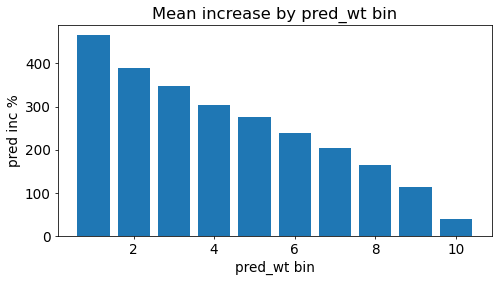

In [15]:
plt.rcParams['figure.dpi'] = 70
plt.rcParams['figure.figsize'] = (8, 4)
plt.bar(x=range(1, 11), height = informed_mut_res.groupby('pred_wt_bin')['percent'].mean())
_ = plt.xlabel('pred_wt bin')
_ = plt.ylabel('pred inc %')
_ = plt.title('Mean increase by pred_wt bin')

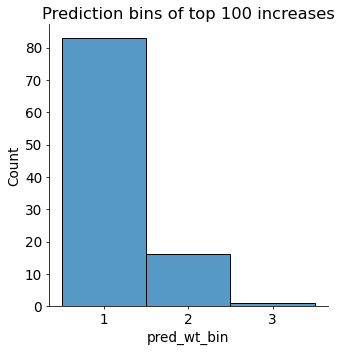

In [16]:
plt.rcParams['figure.dpi'] = 70
sns.displot(
    informed_mut_res.sort_values('percent', ascending=False).head(100)['pred_wt_bin']
)
_ = plt.title('Prediction bins of top 100 increases')

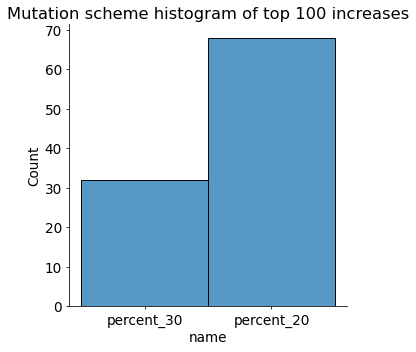

In [17]:
plt.rcParams['figure.dpi'] = 70
sns.displot(
    informed_mut_res.sort_values('percent', ascending=False).head(100)['name']
)
_ = plt.title('Mutation scheme histogram of top 100 increases')

## Most frequent substitutions

In [18]:
def get_diffs(seq_wt:str, seq_mut:str):
    diffs = []
    for i in range(len(seq_wt)):
        if seq_wt[i] != seq_mut[i]:
            diffs.append((i + 1, seq_wt[i], seq_mut[i], len(seq_wt)))
    return pd.DataFrame.from_records(diffs, columns = ['pos', 'aa_wt', 'aa_mut', 'seq_len'])


substitutions = pd.concat(
    informed_mut_res
    .progress_apply(
        lambda row: get_diffs(row['seq_wt'], row['seq_mut']).assign(swissprot_ac = row['swissprot_ac'],
                                                                    scheme = row['name']),
        axis = 'columns'
    ).values,
    ignore_index=True
)

substitutions = substitutions.assign(pos_norm = substitutions['pos'] / substitutions['seq_len'])
substitutions = substitutions.assign(pos_bin = pd.qcut(substitutions['pos_norm'], q = 100, labels=range(1, 101)))

substitutions['pos'] = substitutions['pos'].astype('int32')
substitutions['seq_len'] = substitutions['seq_len'].astype('int32')
substitutions['pos_norm'] = substitutions['pos_norm'].astype('float32')
substitutions['pos_bin'] = substitutions['pos_bin'].astype('int16')

Pandas op: 100%|██████████| 33215/33215 [00:34<00:00, 958.57it/s] 


In [19]:
substitutions.to_csv('mgem_substitutions.csv.gz', index=False, compression='gzip')

In [20]:
MUT_SCHEME = 'percent_20'
POS_LIM = 100

In [21]:
substituted_counts = (
    substitutions
#     .query('scheme == @MUT_SCHEME')
#     .query('pos <= @POS_LIM')
    
    .groupby('pos')['aa_wt'].apply(Counter)
    .fillna(0)
    
    
    .rename('count')
    .reset_index()
    .rename(columns={'level_1': 'aa_wt'})
)

# substituted_counts['count'] = substituted_counts['count'].astype('uint16')

In [22]:
(
    alt.Chart(substituted_counts.query('pos <= 100'))
    
    .mark_bar(size=14).encode(
        
        x=alt.X('pos'),
        y=alt.Y('count', stack='normalize'),
        color='aa_wt',
    
        tooltip='aa_wt'

    ).properties(
        width=800,
        height=400
    ).configure_axis(
        grid=False
    )
)

alt.Chart(...)

In [23]:
substitute_counts = (
    substitutions
#     .query('scheme == @MUT_SCHEME')
#     .query('pos <= @POS_LIM')
    
    .groupby('pos')['aa_mut'].apply(Counter)
    .fillna(0)
    
    .rename('count')
    .reset_index()
    .rename(columns={'level_1': 'aa_mut'})
)

substitute_counts['count'] = substitute_counts['count'].astype('uint16')

In [24]:
(
    alt.Chart(substitute_counts.query('pos <= 100'))
    
    .mark_bar(size=14).encode(
        x=alt.X('pos'),
        y=alt.Y('count', stack='normalize'),
        color='aa_mut',
    
        tooltip='aa_mut'

    ).properties(
        width=800,
        height=400
    ).configure_axis(
        grid=False
    )
)

alt.Chart(...)

In [25]:
subst_pairs = (
    substitutions
#     .query('scheme == @MUT_SCHEME')
#     .query('pos < @POS_LIM')
    
    .groupby(['pos', 'aa_wt', 'aa_mut'])['swissprot_ac'].count()
    .rename('count')
    .reset_index()
    .fillna(0)
)

mean_subst_pairs = (
    subst_pairs
    .groupby(['aa_wt', 'aa_mut'])
    ['count'].mean()
    .reset_index()
)

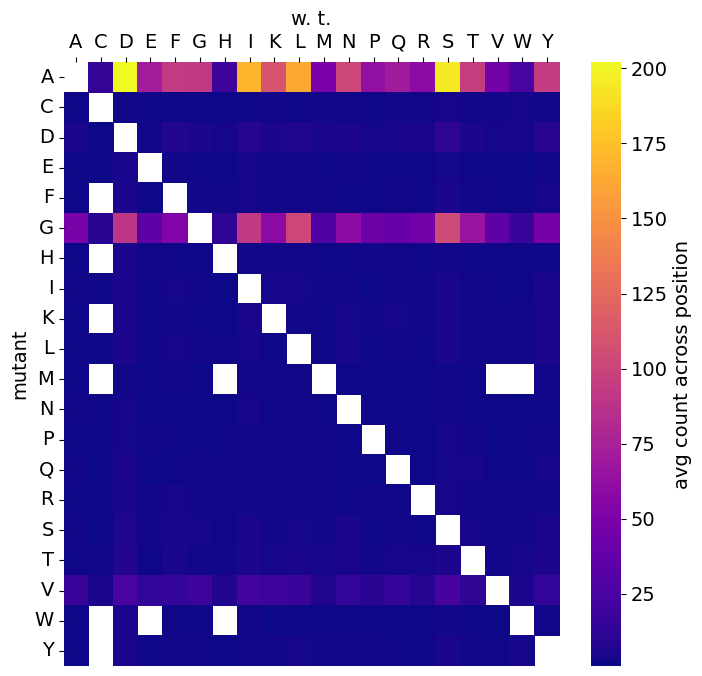

In [26]:
plt.figure(dpi=100, figsize=(8, 8))

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

sns.heatmap(
    mean_subst_pairs.pivot_table(index = 'aa_mut', columns = 'aa_wt', values = 'count'),
    cmap='plasma',
    cbar_kws = {'label': 'avg count across position'}
)

plt.title('w. t.', fontdict={'size': 14})
plt.xlabel('')
plt.ylabel('mutant')
_ = plt.yticks(rotation = 0)


plt.savefig('mut_subst_matrix.pdf')

plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False

## Mutation hotspots

In [27]:
substitutions.head(4)

,pos,aa_wt,aa_mut,seq_len,swissprot_ac,scheme,pos_norm,pos_bin
0,132,I,A,244,P47095,fixed_02,0.540984,54
1,168,D,A,244,P47095,fixed_02,0.688525,69
2,191,D,A,923,P25360,fixed_02,0.206934,19
3,259,D,A,923,P25360,fixed_02,0.280607,26


Text(0, 0.5, 'Substitution density')

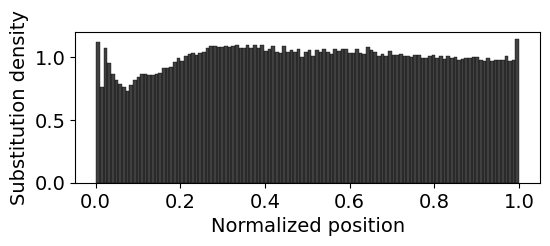

In [28]:
plt.figure(dpi=100, figsize=(6, 2))

sns.histplot(data = substitutions, x = 'pos_norm', color = 'k', stat='density')

plt.xlabel('Normalized position')
plt.ylabel('Substitution density')

In [29]:
replacement_counts = (
    substitutions.query('pos_norm <= 0.2')
    .groupby('aa_mut')['aa_wt'].count()
    .rename('count').reset_index()
)

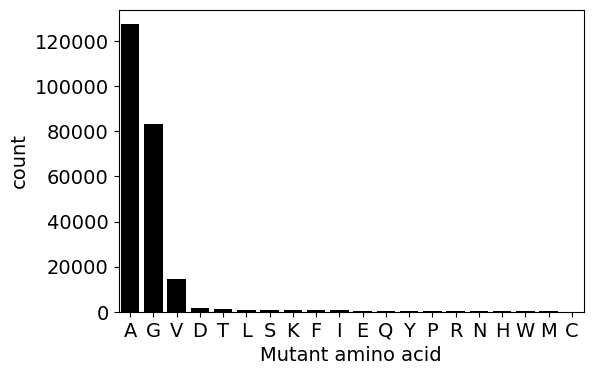

In [30]:
plt.figure(dpi=100, figsize=(6, 4))

sns.barplot(
    data = replacement_counts,
    x = 'aa_mut', y = 'count',
    color = 'k',
    order = replacement_counts.sort_values('count', ascending=False)['aa_mut']
)

plt.xlabel('Mutant amino acid')

plt.savefig('mut_aa_counts.pdf')

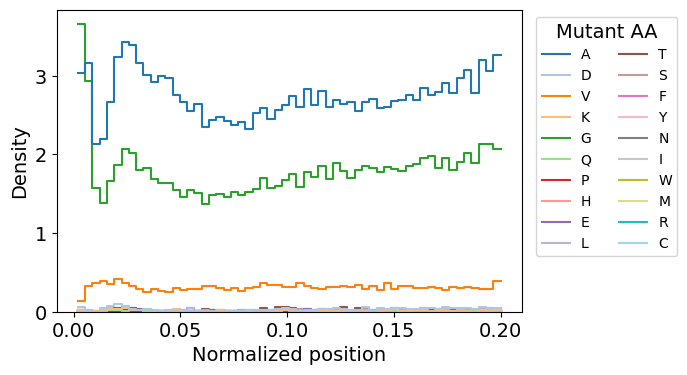

In [31]:
plt.figure(dpi=100, figsize=(6, 4))

mut_aa_list = ['A', 'G', 'V']

g = sns.histplot(
    data = (
        substitutions
#         .query('aa_mut in @mut_aa_list')
        .query('pos_norm <= 0.2')
        .rename(columns = {'aa_mut': 'Mutant AA'})
    ),
    x = 'pos_norm',
    stat = 'density',
    hue = 'Mutant AA',
    fill = False,  element = 'step',
    palette = 'tab20'
)

sns.move_legend(g, 'upper right', bbox_to_anchor=(1.35, 1), fontsize = 10, ncol = 2)

plt.xlabel('Normalized position')

plt.savefig('mutant_aa_nterm.pdf')

<Figure size 800x400 with 0 Axes>

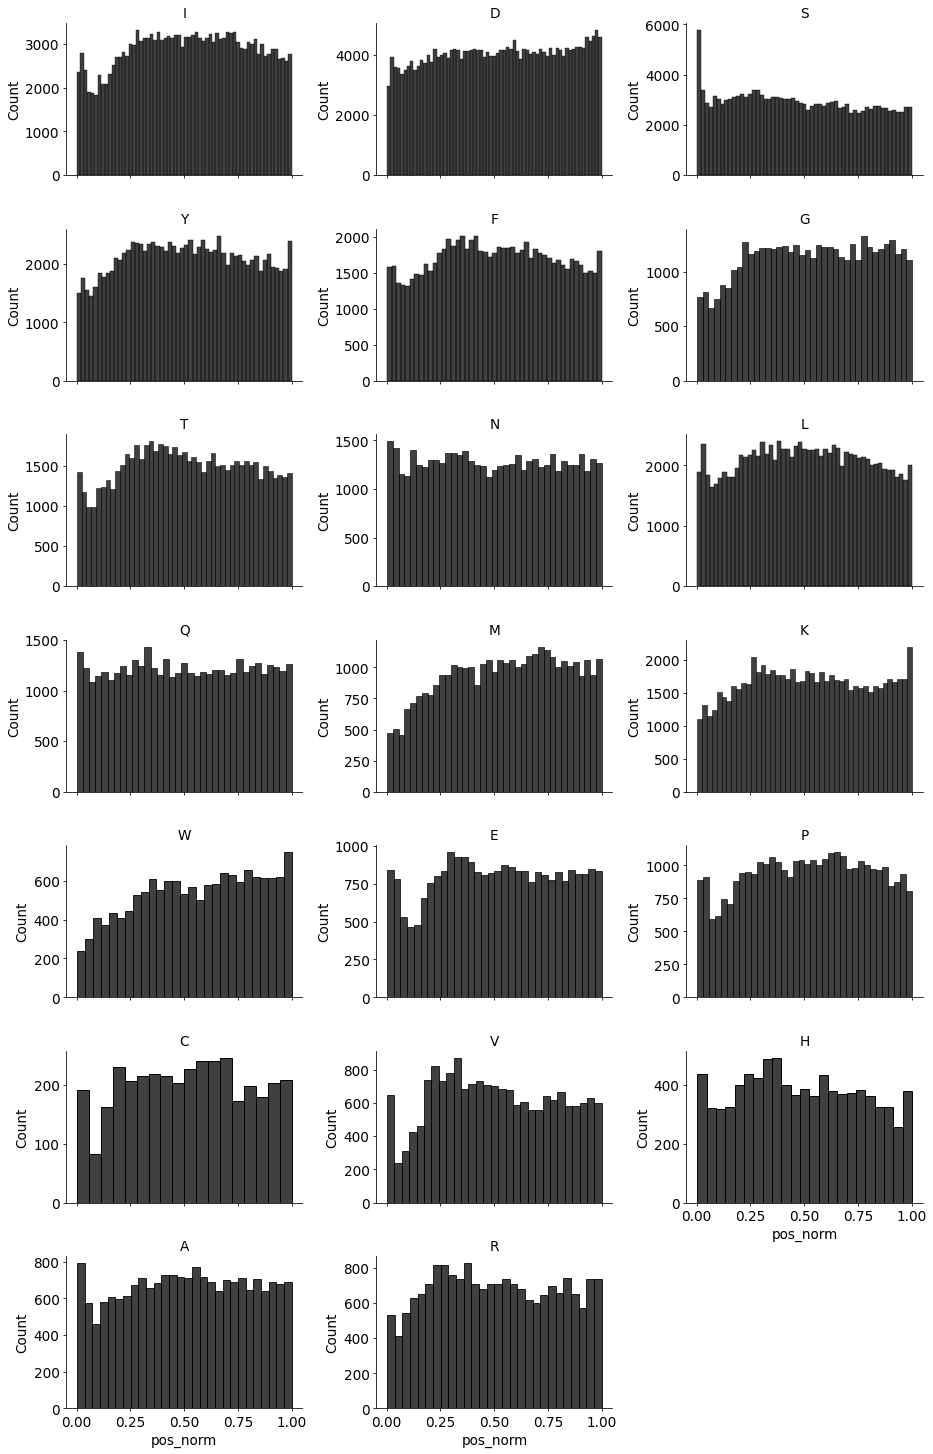

In [32]:
plt.figure(dpi=100)

g = sns.FacetGrid(substitutions, col = 'aa_wt', col_wrap = 3, aspect = 1.5,
                  sharey = False)

g.map(sns.histplot, 'pos_norm', color = 'k')

g.set_titles(col_template="{col_name}") 

### Get background AA counts

In [33]:
sequences = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'seq']
]


def get_aa_count_by_region(seq: str):
    """Count AAs separately for first 30% and the rest of the sequence."""
    split_idx = int(np.floor(len(seq) * 0.3))
    n_term = Counter(seq[:split_idx])
    tail = Counter(seq)
    
    n_term = pd.DataFrame.from_records(
        list(n_term.items()), columns = ['aa', 'count']
    ).assign(region = 'N-term')
    
    tail = pd.DataFrame.from_records(
        list(tail.items()), columns = ['aa', 'count']
    ).assign(region = 'all')
    
    return pd.concat([n_term, tail], ignore_index=True)


background_aa_counts = sequences['seq'].progress_map(get_aa_count_by_region)
background_aa_counts = pd.concat(background_aa_counts.values, ignore_index=False)
background_aa_counts = background_aa_counts.groupby(['region', 'aa']).sum().reset_index()

Pandas op: 100%|██████████| 4750/4750 [00:08<00:00, 529.58it/s]


In [34]:
background_aa_counts = pd.merge(
    background_aa_counts,

    background_aa_counts.groupby('region').apply(
        lambda grp_df: (
            grp_df.assign(fract = grp_df['count'] / grp_df['count'].sum())
            .drop(columns = ['region', 'count'])
        )
    ).reset_index().drop(columns='level_1'),
    
    on = ['region', 'aa']
)

<AxesSubplot:xlabel='aa', ylabel='fract'>

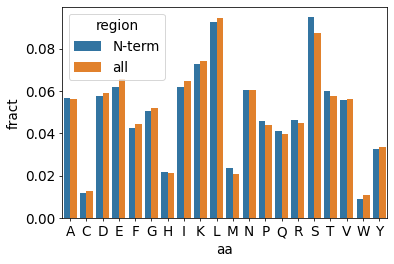

In [35]:
plt.figure(dpi = 70, figsize = (6, 4))

sns.barplot(
    data = background_aa_counts,
    x = 'aa',
    y = 'fract',
    hue = 'region'
)

In [36]:
aa_freq_nterm_deviations = analysis.hypergeom_test_aa_counts(
    pd.merge(
        background_aa_counts.query('region == "N-term"')[['aa', 'count']],

        (background_aa_counts.query('region != "N-term"')[['aa', 'count']]
         .rename(columns = {'count': 'background_count'})),

        on = 'aa'
    )
)

display(
    aa_freq_nterm_deviations.query('pval_over < 0.05').drop(columns = 'pval_under'),
    aa_freq_nterm_deviations.query('pval_under < 0.05').drop(columns = 'pval_over')
)

,aa,pval_over
0,A,9.679602e-04
6,H,2.059567e-03
10,M,5.330124e-76
12,P,7.746553e-22
13,Q,1.768194e-10
14,R,3.393047e-08
15,S,2.381427e-128
16,T,4.209202e-24


,aa,pval_under
1,C,3.849427e-15
2,D,3.104653e-08
3,E,1.043352e-49
4,F,1.895432e-15
5,G,2.204858e-08
7,I,1.693833e-22
8,K,8.558290e-08
9,L,6.875738e-09
17,V,4.648197e-04
18,W,3.563835e-44


### Normalize substitute counts by background AA counts at each position

In [37]:
N_DECIMALS = 2

In [38]:
def count_aa_occurences(seq):
    return pd.DataFrame(
        [[seq[i], i, i / len(seq)] for i in range(len(seq))],
        columns = ['aa', 'pos', 'pos_norm']
    )

aa_pos_counts = pd.concat(
    sequences['seq'].progress_map(count_aa_occurences).values, 
    ignore_index=True
).query('pos > 0')

Pandas op: 100%|██████████| 4750/4750 [00:02<00:00, 1872.61it/s]


In [39]:
aa_pos_counts = aa_pos_counts.assign(
    pos_norm_binned = np.around(aa_pos_counts['pos_norm'], decimals = N_DECIMALS).map(
        lambda val: f'{val:.{N_DECIMALS}f}'
    )
)

aa_pos_counts = (
    aa_pos_counts
    .groupby(['pos_norm_binned', 'aa'])['pos']
    .count()
    .rename('count_per_bin').reset_index()
)

aa_pos_counts = aa_pos_counts.groupby('pos_norm_binned').apply(
    lambda grp_df: (
        grp_df.assign(
            fract_per_bin = grp_df['count_per_bin'] / grp_df['count_per_bin'].sum()
         )
        .drop(columns = ['pos_norm_binned'])
    )
).reset_index().drop(columns='level_1')

In [40]:
subst_counts = substitutions.assign(
    pos_norm_binned = np.around(substitutions['pos_norm'], decimals = N_DECIMALS).map(
        lambda val: f'{val:.{N_DECIMALS}f}'
    )
)[['aa_wt', 'pos_norm', 'pos_norm_binned']]

subst_counts = (
    subst_counts
    .groupby(['pos_norm_binned', 'aa_wt'])['pos_norm']
    .count()
    .rename('count_per_bin').reset_index()
)

subst_counts = subst_counts.groupby('pos_norm_binned').apply(
    lambda grp_df: (
        grp_df.assign(
            fract_per_bin = grp_df['count_per_bin'] / grp_df['count_per_bin'].sum()
        )
        .drop(columns = ['pos_norm_binned'])
    )
).reset_index().drop(columns='level_1')

In [41]:
subst_and_background_aa_counts = pd.merge(
    subst_counts,
    aa_pos_counts.rename(columns = {'count_per_bin': 'background_count_per_bin',
                                    'fract_per_bin': 'background_fract_per_bin'}),
    left_on = ['pos_norm_binned', 'aa_wt'], right_on = ['pos_norm_binned', 'aa']
)

In [42]:
pos_norm_binned_vals = subst_and_background_aa_counts['pos_norm_binned'].unique()
pos_norm_binned_vals = pd.DataFrame.from_records(
    sorted(
        zip(
            pos_norm_binned_vals,
            np.argsort(pos_norm_binned_vals)
        ),
        key=lambda x: x[1]
    ),
    columns = ['pos_norm_binned', 'pos_norm_bin']
)

subst_and_background_aa_counts = subst_and_background_aa_counts.merge(pos_norm_binned_vals)

In [43]:
subst_and_background_aa_counts = subst_and_background_aa_counts.assign(
    occurrence_norm = (subst_and_background_aa_counts['count_per_bin'] 
                       / subst_and_background_aa_counts['background_count_per_bin'])
)

In [44]:
subst_and_background_aa_counts = (
    subst_and_background_aa_counts
    .groupby('aa')
    .apply(
        lambda grp_df: grp_df.assign(
            occurrence_zscore = stats.zscore(grp_df['occurrence_norm'])
        )
    ).drop(columns='aa').reset_index().drop(columns='level_1')
)

In [45]:
subst_and_background_aa_counts.head(6)

,aa,pos_norm_binned,aa_wt,count_per_bin,fract_per_bin,background_count_per_bin,background_fract_per_bin,pos_norm_bin,occurrence_norm,occurrence_zscore
0,A,0.00,A,175,0.036001,518,0.066607,0,0.337838,5.216111
1,A,0.01,A,156,0.012973,1145,0.055946,1,0.136245,-0.920964
2,A,0.02,A,142,0.010638,1269,0.061924,2,0.111899,-1.662108
3,A,0.03,A,255,0.019215,1273,0.062442,3,0.200314,1.029499
4,A,0.04,A,178,0.015030,1242,0.060858,4,0.143317,-0.705652
5,A,0.05,A,203,0.018252,1236,0.060550,5,0.164239,-0.068718


In [46]:
subst_and_background_aa_counts.to_csv('yeast_result_mgem_substitution_rates.csv', index=False)

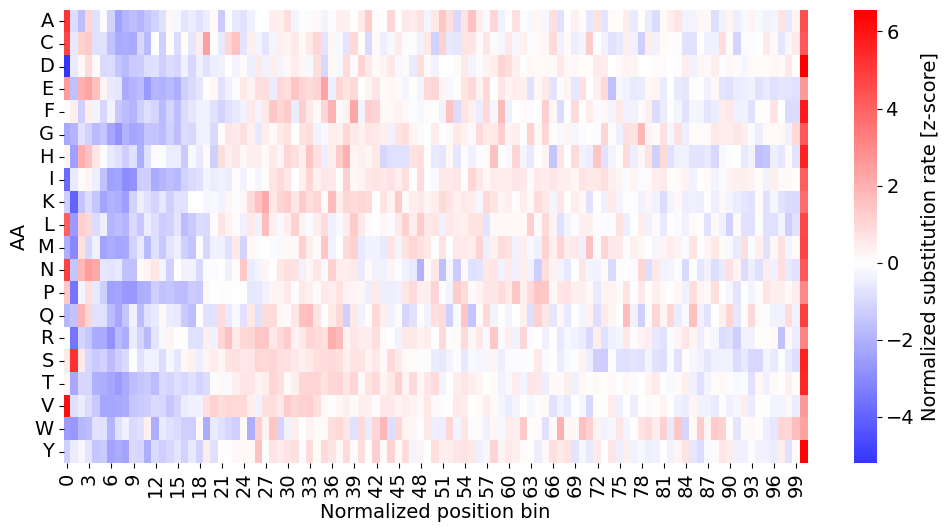

In [47]:
plt.figure(dpi=100, figsize = (12, 6))

sns.heatmap(
    data = (
        subst_and_background_aa_counts
        .pivot_table(index = 'aa', columns = 'pos_norm_bin', values = 'occurrence_zscore')
    ),
    cmap = 'bwr',
    center=0,
    cbar_kws = {'label': 'Normalized substitution rate [z-score]'}
)

# _ = plt.xticks(rotation = 15)
_ = plt.yticks(rotation = 0)
_ = plt.ylabel('AA')
_ = plt.xlabel('Normalized position bin')

plt.savefig('mutation_hotspots.pdf')

In [48]:
hydrophob_vals = aaindex['CIDH920105']['values']
polar_req_vals = aaindex['WOEC730101']['values']

color_norm_hp = plt.Normalize(vmin = -max(np.abs(list(hydrophob_vals.values()))),
                              vmax = max(np.abs(list(hydrophob_vals.values()))))
color_map_hp = cm.get_cmap('bwr')

color_norm_pr = plt.Normalize(min(polar_req_vals.values()), max(polar_req_vals.values()))
color_map_pr = cm.get_cmap('plasma')

In [49]:
# mean_replaced_aa_fract_per_bin = (    
#     subst_and_background_aa_counts
#     .query('pos_norm_bin <= 30')
#     .groupby('aa')
#     ['fract_per_bin'].mean()
#     .rename('mean_fract_per_bin')
#     .reset_index()
#     .sort_values('mean_fract_per_bin', ascending=False)
# )

nterm_replaced_aa_fract_per_bin = subst_and_background_aa_counts.query('pos_norm_bin <= 30')
nterm_replaced_aa_fract_per_bin.to_csv('replaced_aa_fract_per_bin.csv', index=False)

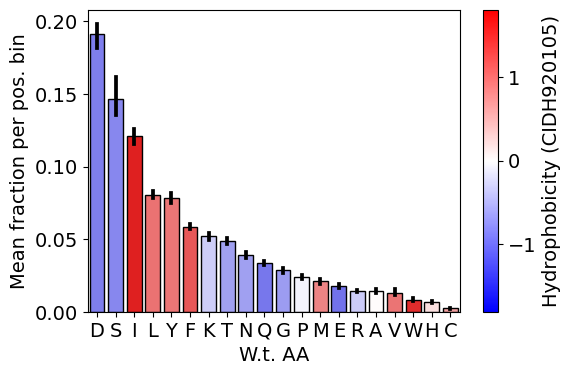

In [50]:
plt.figure(dpi=100, figsize=(6, 4))

g = sns.barplot(
    data = nterm_replaced_aa_fract_per_bin,
    x = 'aa',
    y = 'fract_per_bin',
    order = (
        nterm_replaced_aa_fract_per_bin
        .groupby('aa')
        ['fract_per_bin'].mean()
        .sort_values(ascending=False).index.values
    ),
    palette = {
        k: color_map_hp(color_norm_hp(v)) for k, v in hydrophob_vals.items()    
    },
    edgecolor = 'k',
    errcolor = 'k'
)
plt.colorbar(cm.ScalarMappable(norm=color_norm_hp, cmap=color_map_hp), 
             label = 'Hydrophobicity (CIDH920105)')

plt.xlabel('W.t. AA')
plt.ylabel('Mean fraction per pos. bin')

plt.savefig('mean_replaced_aa_fract_per_bin.pdf')

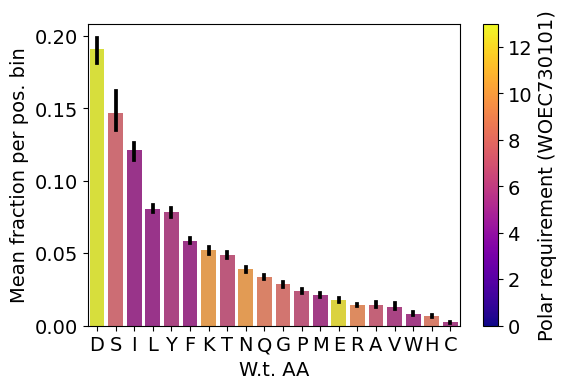

In [51]:
plt.figure(dpi=100, figsize=(6, 4))

g = sns.barplot(
    data = nterm_replaced_aa_fract_per_bin,
    x = 'aa',
    y = 'fract_per_bin',
    order = (
        nterm_replaced_aa_fract_per_bin
        .groupby('aa')
        ['fract_per_bin'].mean()
        .sort_values(ascending=False).index.values
    ),
    palette = {
        k: color_map_pr(color_norm_pr(v)) for k, v in polar_req_vals.items()    
    },
    errcolor = 'k'
)
plt.colorbar(cm.ScalarMappable(norm=color_norm_pr, cmap=color_map_pr), 
             label = 'Polar requirement (WOEC730101)')

plt.xlabel('W.t. AA')
plt.ylabel('Mean fraction per pos. bin')

plt.savefig('mean_replaced_aa_fract_per_bin.pdf')

### Show mutant fractions

In [52]:
nterm_mut_aa_counts = (
    substitutions
    .query('pos_norm <= 0.03')
    .assign(
        pos_norm_binned = np.around(substitutions['pos_norm'], decimals = N_DECIMALS).map(
            lambda val: f'{val:.{N_DECIMALS}f}'
        )
    )
)

nterm_mut_aa_counts = (
    nterm_mut_aa_counts
    .groupby(['pos_norm_binned', 'aa_mut'])['pos']
    .count()
    .rename('mut_count_per_bin').reset_index()
)

nterm_mut_aa_counts = nterm_mut_aa_counts.groupby('pos_norm_binned').apply(
    lambda grp_df: (
        grp_df.assign(
            mut_fract_per_bin = grp_df['mut_count_per_bin'] / grp_df['mut_count_per_bin'].sum()
         )
        .drop(columns = ['pos_norm_binned'])
    )
).reset_index().drop(columns='level_1')

In [53]:
mean_mut_aa_fract_per_bin = (    
    nterm_mut_aa_counts
    .groupby('aa_mut')
    ['mut_fract_per_bin'].mean()
    .rename('mean_mut_fract_per_bin')
    .reset_index()
    .sort_values('mean_mut_fract_per_bin', ascending=False)
)

mean_mut_aa_fract_per_bin.to_csv('mutant_aa_fract_per_bin.csv', index=False)

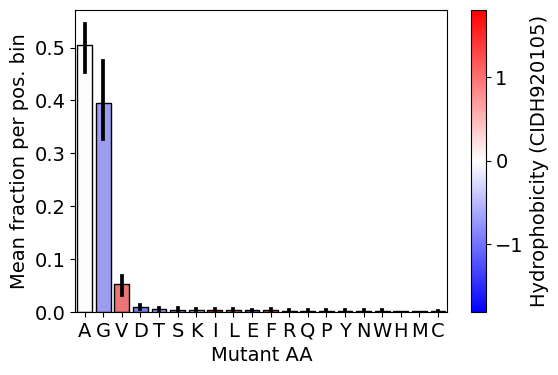

In [54]:
plt.figure(dpi=100, figsize=(6, 4))

sns.barplot(
    data = nterm_mut_aa_counts,
    x = 'aa_mut',
    y = 'mut_fract_per_bin',
    order = (
        nterm_mut_aa_counts
        .groupby('aa_mut')
        ['mut_fract_per_bin'].mean()
        .sort_values(ascending=False).index.values
    ),
    palette = {
        k: color_map_hp(color_norm_hp(v)) for k, v in hydrophob_vals.items()    
    },
    edgecolor = 'k',
    errcolor = 'k'
)
plt.colorbar(cm.ScalarMappable(norm=color_norm_hp, cmap=color_map_hp), 
             label = 'Hydrophobicity (CIDH920105)')

plt.xlabel('Mutant AA')
plt.ylabel('Mean fraction per pos. bin')

plt.savefig('mean_mut_aa_fract_per_bin.pdf')

## Mutant costs

In [56]:
from Bio.PDB.Polypeptide import three_to_one

with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)

aa_costs = pd.read_csv('../../data/aa_costs/aa_costs_barton.csv')
aa_costs['amino_acid'] = aa_costs['amino_acid'].map(lambda aa: three_to_one(aa.upper()))
aa_costs = aa_costs.drop(
    columns=['ecoli_car_abs', 'ecoli_car_rel', 'ecoli_nit_abs', 'ecoli_nit_rel', 'ecoli_sul_abs', 'ecoli_sul_rel',
             'yeast_sul_abs', 'yeast_sul_rel', 'yeast_nit_abs']
)
cost_names = list(filter(lambda name: name != 'amino_acid', aa_costs.columns))


from rpy2.robjects.packages import importr
from rpy2 import robjects
import matplotlib

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

bio3d = importr('bio3d')

aa_letters = sorted(aa_costs['amino_acid'].unique())
aa_pol_vals = np.array(bio3d.aa2index(robjects.StrVector(aa_letters), index = 'WOEC730101', window = 1))
polar_req = pd.DataFrame.from_records(zip(aa_letters, aa_pol_vals), columns = ['amino_acid', 'pI'])


aa_pol_vals = np.array(bio3d.aa2index(robjects.StrVector(aa_letters), index = 'CIDH920105', window = 1))
aa_hydro = pd.DataFrame.from_records(zip(aa_letters, aa_pol_vals), 
                                     columns = ['amino_acid', 'Normalized average hydrophobicity'])

In [57]:
aa_in_substs = ['D', 'S', 'I', 'L', 'A', 'G', 'V']
top_mutant_aa = ['A', 'G', 'V']

subst_aa_costs = (
    aa_costs
    .merge(polar_req)
    .merge(aa_hydro)
    .query('amino_acid in @aa_in_substs')   
)

subst_aa_costs = subst_aa_costs.assign(
    presence = subst_aa_costs['amino_acid'].map(lambda aa: 'mut' if aa in top_mutant_aa else 'w.t.')
)

subst_aa_costs.sort_values('presence')

,amino_acid,akashi,craig_energy,craig_steps,wagner_ferm,wagner_resp,weight,yeast_car_abs,yeast_car_rel,yeast_nit_rel,pI,Normalized average hydrophobicity,presence
0,A,11.7,12.5,1,2,14.5,89.1,0.500,0.223,0.820,7.0,0.02,mut
7,G,11.7,14.5,4,1,14.5,75.1,0.307,0.087,0.519,7.9,-0.80,mut
19,V,23.3,25.0,4,4,29.0,117.2,0.957,0.246,0.473,5.6,1.13,mut
3,D,12.7,1.0,1,3,15.5,133.1,0.614,0.178,0.532,13.0,-1.04,w.t.
9,I,32.3,20.0,11,14,38.0,131.2,1.207,0.226,0.345,4.9,1.81,w.t.
10,L,27.3,33.0,7,4,37.0,131.2,1.207,0.348,0.530,4.9,1.14,w.t.
15,S,11.7,15.0,3,1,14.5,105.1,0.493,0.089,0.332,7.5,-0.97,w.t.


/home/fburic/miniconda3/envs/DeepTranslation/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


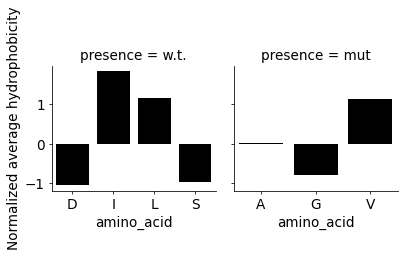

In [58]:
g = sns.FacetGrid(data = subst_aa_costs.sort_values('presence', ascending=False),
                  col = 'presence', sharex=False, sharey=True)

g.map(sns.barplot, 'amino_acid', 'Normalized average hydrophobicity', color = 'k')

/home/fburic/miniconda3/envs/DeepTranslation/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


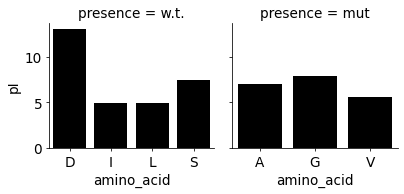

In [59]:
g = sns.FacetGrid(data = subst_aa_costs.sort_values('presence', ascending=False),
                  col = 'presence', sharex=False, sharey=True)

g.map(sns.barplot, 'amino_acid', 'pI', color = 'k')

/home/fburic/miniconda3/envs/DeepTranslation/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


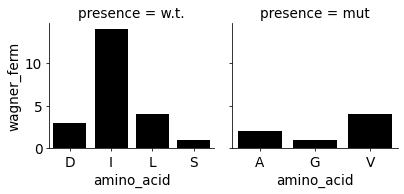

In [60]:
g = sns.FacetGrid(data = subst_aa_costs.sort_values('presence', ascending=False),
                  col = 'presence', sharex=False, sharey=True)

g.map(sns.barplot, 'amino_acid', 'wagner_ferm', color = 'k')

/home/fburic/miniconda3/envs/DeepTranslation/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


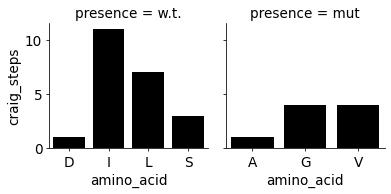

In [61]:
g = sns.FacetGrid(data = subst_aa_costs.sort_values('presence', ascending=False),
                  col = 'presence', sharex=False, sharey=True)

g.map(sns.barplot, 'amino_acid', 'craig_steps', color = 'k')

/home/fburic/miniconda3/envs/DeepTranslation/lib/python3.8/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


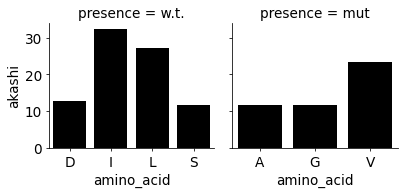

In [62]:
g = sns.FacetGrid(data = subst_aa_costs.sort_values('presence', ascending=False),
                  col = 'presence', sharex=False, sharey=True)

g.map(sns.barplot, 'amino_acid', 'akashi', color = 'k')